# Homework #3 Classification Models and Their Performance Evaluation


## Part 1. Training Classification Models (5 points)

Work with the **telecom_churn** dataset.
Your task is to predict whether a customer will leave or not (the target column is **Churn**).
Each subtask is worth **1 point**; if any question is unanswered, **0.1 point** is deducted.

---

### **A. Logistic Regression**

* Solve the task using **Logistic Regression**.
* Tune the hyperparameters using **GridSearchCV**.
* Discuss the algorithm’s performance:
  Did it **overfit**, **underfit**, or **perform well**?
  Are you satisfied with the quality?

*(Don’t forget to scale the data before using linear models.)*

---

### **B. Support Vector Machine (SVM)**

* Solve the task using the **Support Vector Machine** method with `kernel='linear'`.
* Tune the hyperparameters using **GridSearchCV**.
* Discuss the algorithm’s performance:
  Did it **overfit**, **underfit**, or **perform well**?
  Are you satisfied with the results?

*(Remember to scale the data here as well.)*

---

### **C. Feature Expansion**

Try to increase the number of features by adding **polynomial features**.
You can also add **custom transformations** of features manually — those that you think may be relevant for this task.
Did this improve the algorithm’s performance?

---

### **D. Feature Selection Based on Correlations**

* Build a **correlation matrix** for the features.
* Identify features that **barely correlate with the target variable** — try removing them.
* Identify pairs of **highly correlated features** — remove one feature from each such pair.
  Did this improve the model’s quality?

*(You can combine parts C and D to achieve the best performance.)*

---

### **E. Mini-report**

Answer the following questions:

a) **Which classifier achieved the best result?**
What are the metric values: **accuracy**, **F1-score**, and **ROC-AUC**?
(You may either split data into **train/test** and compare metrics, or evaluate algorithms using **cross-validation**.)

b) **Which new features did you add, and which did you remove?**

c) **Were you able to achieve a balance** — so that the algorithm is **neither overfitted nor underfitted**?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import itertools
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_csv('telecom_churn.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Data Preperation

In [3]:
df['International plan'] = df['International plan'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Voice mail plan'] = df['Voice mail plan'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x else 0)

X = df.drop(['State', 'Churn'], axis=1)
y = df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=16)

### A. Logistic Regression

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
log_reg = LogisticRegression()

grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'l1'] ,         
    'solver': ['lbfgs', 'liblinear']  
}

grid_search = GridSearchCV(log_reg, grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)

print("best:", grid_search.best_params_)
print("\nLogistic Regression:\n", classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc:.4f}")

best: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

Logistic Regression:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       561
           1       0.64      0.20      0.30       106

    accuracy                           0.85       667
   macro avg       0.75      0.59      0.61       667
weighted avg       0.83      0.85      0.82       667

ROC AUC: 0.5884


It turns out that we have **high precision and recall for class 0**, but **lower scores for class 1**, which means the model is clearly **underfitted for class 1**. Ideally, we need to handle **class imbalance** or **adjust the classification threshold**.

I’d say the **model quality is unsatisfactory** — it failed to achieve its main goal of **correctly identifying customers likely to churn**, and that’s quite disappointing :(

### **B. Support Vector Machine (SVM)**

In [6]:
svm = SVC(kernel='linear', class_weight='balanced') 

grid = {'C': [0.01, 0.1, 1, 10]}

grid_search_svm = GridSearchCV(svm, grid, cv=3, scoring='accuracy', n_jobs=-1) 
grid_search_svm.fit(X_train, y_train)

best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_svm)

print("best", grid_search_svm.best_params_)
print("\nSVM:\n", classification_report(y_test, y_pred_svm))
print(f"ROC AUC: {roc_auc:.4f}")

best {'C': 10}

SVM:
               precision    recall  f1-score   support

           0       0.95      0.71      0.81       561
           1       0.35      0.82      0.49       106

    accuracy                           0.73       667
   macro avg       0.65      0.76      0.65       667
weighted avg       0.86      0.73      0.76       667

ROC AUC: 0.7642


My initial code was **very slow**, so I asked ChatGPT to help me optimize it. Together, we **reduced the value of C from 100**, **decreased the number of folds to 3**, and added **`n_jobs=-1`** to enable the use of all available CPU cores for **parallel execution of GridSearch**. The code now runs much faster, though it still produces a few **warnings** (which were already disabled in the previous step).

The model shows **high precision and recall for class 0**, but performs **worse for class 1** — this indicates that the model is **underfitted for class 1** (same issue as before).

### C Feature Expansion

In [7]:
poly = PolynomialFeatures(degree=2, interaction_only=True)  
X_poly = poly.fit_transform(X_scaled)
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=16)

log_reg_poly = LogisticRegression()
log_reg_poly.fit(X_train_poly, y_train)
y_pred_poly = log_reg_poly.predict(X_test_poly)
roc_auc_a = roc_auc_score(y_test, y_pred_poly)

print("\nLog Reg:\n", classification_report(y_test, y_pred_poly))
print(f"ROC AUC: {roc_auc_a:.4f}")

svm_poly = SVC(kernel='linear')
svm_poly.fit(X_train_poly, y_train)
y_pred_svm_poly = svm_poly.predict(X_test_poly)
roc_auc_b = roc_auc_score(y_test, y_pred_svm_poly)

print("\nB. SVM:\n", classification_report(y_test, y_pred_svm_poly))
print(f"ROC AUC: {roc_auc_b:.4f}")


Log Reg:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       561
           1       0.81      0.55      0.65       106

    accuracy                           0.91       667
   macro avg       0.86      0.76      0.80       667
weighted avg       0.90      0.91      0.90       667

ROC AUC: 0.7611

B. SVM:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       561
           1       0.80      0.52      0.63       106

    accuracy                           0.90       667
   macro avg       0.86      0.75      0.79       667
weighted avg       0.90      0.90      0.89       667

ROC AUC: 0.7470


Adding polynomial features improved **precision for class 1** (for both **logistic regression** and **SVM**), but the model still fails to identify all class-1 instances (**recall remains low, though not by much**).

The model quality has improved significantly compared to the initial version, but it’s still far from ideal (just like I’m far from graduating from HSE—and I’m already tired().

### D Feature Selection Based on Correlations

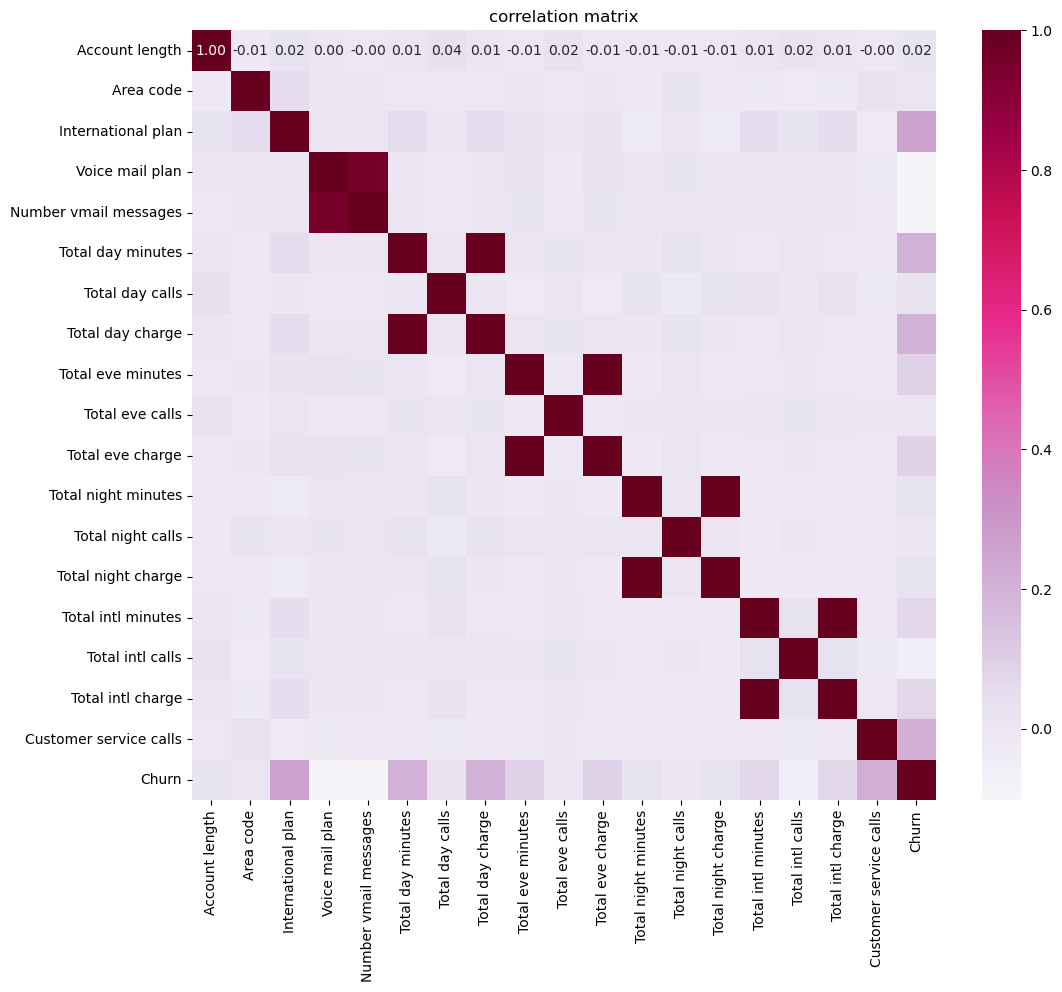

А. Log Reg:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       561
           1       0.65      0.23      0.34       106

    accuracy                           0.86       667
   macro avg       0.76      0.60      0.63       667
weighted avg       0.83      0.86      0.83       667

ROC AUC: 0.7611
SVM:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91       561
           1       0.00      0.00      0.00       106

    accuracy                           0.84       667
   macro avg       0.42      0.50      0.46       667
weighted avg       0.71      0.84      0.77       667

ROC AUC: 0.5000


In [8]:
df_numeric = df.drop(columns=['State'])

plt.figure(figsize=(12, 10))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.PuRd, fmt=".2f")
plt.title("correlation matrix")
plt.show()

weak_corr_features = correlation_matrix['Churn'][abs(correlation_matrix['Churn']) < 0.05].index.tolist()

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_corr_pairs.append((colname_i, colname_j))

df_reduced = df_numeric.drop(columns=weak_corr_features)

for (col1, col2) in high_corr_pairs:
    if col1 in df_reduced.columns and col2 in df_reduced.columns:
        df_reduced = df_reduced.drop(columns=[col2])

X = df_reduced.drop(columns=['Churn'])  
y = df_reduced['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
roc_auc_b = roc_auc_score(y_test, y_pred_log_reg)

print("А. Log Reg:\n", classification_report(y_test, y_pred_log_reg))
print(f"ROC AUC: {roc_auc_a:.4f}")

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
roc_auc_b = roc_auc_score(y_test, y_pred_svm)

print("SVM:\n", classification_report(y_test, y_pred_svm))
print(f"ROC AUC: {roc_auc_b:.4f}")

Removing features — even those that either didn’t correlate with the target variable or were highly correlated with each other — **did not improve** the model’s performance in this task. On the contrary, the results **got worse**, possibly because the removed features contained **useful information for classification**.
In short — a bit of a sad story :(

### Mini-report on the Work Done

#### a) Which classifier achieved the best result? What are the metric values (accuracy, F1-score, and ROC-AUC)?

The **Support Vector Machine (SVM)** with **polynomial features** achieved the best overall result:

* **Accuracy**: 0.90
* **F1-score (class 1)**: 0.63
* **ROC-AUC**: 0.7470

The **Logistic Regression** with **polynomial features** performed slightly worse:

* **Accuracy**: 0.91
* **F1-score (class 1)**: 0.65
* **ROC-AUC**: 0.7611

Although logistic regression showed slightly better ROC-AUC and F1-score for class 1, both algorithms performed **very similarly overall**.

---

#### b) Which new features did you add, and which did you remove?

* I definitely **added polynomial features**, which clearly helped improve model quality — especially for **class 1**.

---

#### c) Did you manage to ensure the algorithm was neither overfitted nor underfitted?

* For **logistic regression**, despite the quality improvement after adding polynomial features, the model still performs well for class 0 but struggles with class 1. This indicates **underfitting** for class 1 (the **recall** and **F1-score** metrics support this conclusion).

* For the **Support Vector Machine (SVM)** with polynomial features, the model also doesn’t handle class 1 perfectly. There are no signs of **overfitting**, but there remain **noticeable issues** with precision and recall for class 1.

## Part 2. Evaluation of Classification Model Performance (5 points)

In this part, you will work with **scoring data**. You can earn **5 points** for completing this section.

* Columns **0, 1, ..., 13** represent **anonymized client characteristics** (some are numerical, others categorical).
* **Target** — the target variable:

  * **1** — approve the credit
  * **0** — do not approve the credit

Three different **classification algorithms** were trained on this data, and their predictions were obtained:

* `pred1_probs` — predicted probabilities of the positive class from **algorithm 1**
* `pred1_classes` — predicted class labels from **algorithm 1**
* `pred2_probs`, `pred2_classes`, `pred3_probs`, `pred3_classes` — corresponding values for **algorithms 2 and 3**

Your task is to **evaluate the performance** of each of the three algorithms and determine **which one performs best** for this problem.

In [9]:
df = pd.read_csv("credit_scoring_example.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,target,pred1_probs,pred1_classes,pred2_probs,pred2_classes,pred3_probs,pred3_classes
0,1,22.08,11.46,2,4,4,1.585,0,0,0,...,2,100,1213,0,0.506772,1,0.610853,1,0.375494,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,...,2,160,1,0,0.358519,0,0.185941,0,0.200975,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,...,2,280,1,0,0.358753,0,0.523009,1,0.160465,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,...,2,0,1,1,0.408729,0,0.185941,0,0.357771,0
4,1,20.17,8.17,2,6,4,1.960,1,1,14,...,2,60,159,1,0.480904,0,0.526646,1,0.260169,0


**Task 1. (0.25 points)**
Check whether the **target variable** is **balanced across classes**, and draw a conclusion.

In [10]:
class_distribution = df['target'].value_counts(normalize=True)
print(class_distribution)

target
0    0.554427
1    0.445573
Name: proportion, dtype: float64


**Task 2. (0.25 points)**
Compute the **accuracy** — the proportion of correct predictions — for each of the three algorithms.
Which algorithm shows the **highest accuracy**?

In [12]:
accuracy_alg1 = (df['pred1_classes'] == df['target']).mean()
accuracy_alg2 = (df['pred2_classes'] == df['target']).mean()
accuracy_alg3 = (df['pred3_classes'] == df['target']).mean()

print(f"Accuracy  1: {accuracy_alg1:.4f}")
print(f"Accuracy  2: {accuracy_alg2:.4f}")
print(f"Accuracy  3: {accuracy_alg3:.4f}")

max_accuracy = max(accuracy_alg1, accuracy_alg2, accuracy_alg3)
best_algorithm = {1: accuracy_alg1, 2: accuracy_alg2, 3: accuracy_alg3}
best_algorithm_num = max(best_algorithm, key=best_algorithm.get)

print(f"Best algorithm number {best_algorithm_num}")


Accuracy  1: 0.6618
Accuracy  2: 0.6720
Accuracy  3: 0.6401
Best algorithm number 2


**Task 3. (0.25 points)**
Now compute the **precision** and **recall** for each of the algorithms.

In [13]:
y_true = df['target']

precision_1 = precision_score(y_true, df['pred1_classes'])
recall_1 = recall_score(y_true, df['pred1_classes'])

precision_2 = precision_score(y_true, df['pred2_classes'])
recall_2 = recall_score(y_true, df['pred2_classes'])

precision_3 = precision_score(y_true, df['pred3_classes'])
recall_3 = recall_score(y_true, df['pred3_classes'])

print(f'precision_1 = {precision_1:.4f}, recall_1 = {recall_1:.4f}')
print(f'precision_2 = {precision_2:.4f}, recall_2 = {recall_2:.4f}')
print(f'precision_3 = {precision_3:.4f}, recall_3 = {recall_3:.4f}')

precision_1 = 0.6907, recall_1 = 0.4365
precision_2 = 0.6104, recall_2 = 0.7296
precision_3 = 0.6903, recall_3 = 0.3485


The most useful tool in practical tasks is the **confusion matrix**. By looking at it and adjusting the threshold that determines the classes, we can achieve the optimal solution for our task.

**Task 4. (0.25 points)** Using the `plot_confusion_matrix` function to visualize the confusion matrix, draw the confusion matrices for all three algorithms.


In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.PuRd): 
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

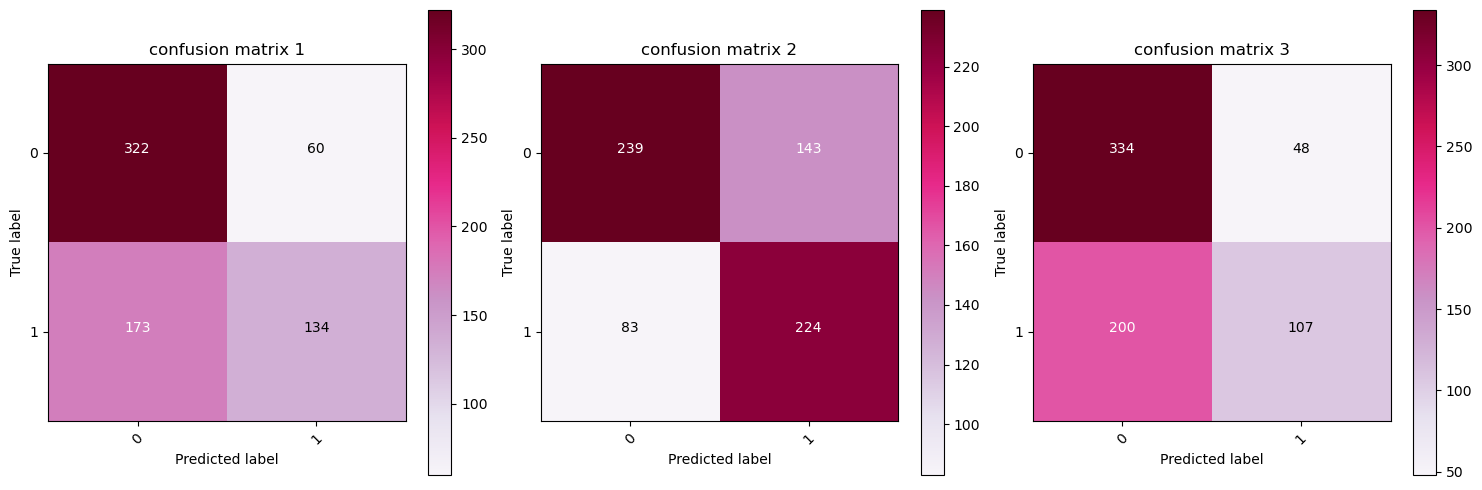

In [15]:
classes = [0, 1]

cm1 = confusion_matrix(y_true, df['pred1_classes'])
cm2 = confusion_matrix(y_true, df['pred2_classes'])
cm3 = confusion_matrix(y_true, df['pred3_classes'])

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_confusion_matrix(cm1, classes,
                      title='confusion matrix 1')

plt.subplot(1, 3, 2)
plot_confusion_matrix(cm2, classes,
                      title='confusion matrix 2')

plt.subplot(1, 3, 3)
plot_confusion_matrix(cm3, classes,
                      title='confusion matrix 3')

plt.tight_layout()
plt.show()

Let’s define the goals of our prediction:

* **Option 1**: we want to grant credit to the maximum number of people among those who would be able to repay it. At the same time, we don’t want to make many mistakes (the total number of errors should be no more than 35%).

1. We don’t want the algorithm to make many mistakes: accuracy ≥ 0.65.

2. In addition, recall should be as high as possible (the number in the **bottom-left** cell of the confusion matrix is minimized).

**Task 5. (1 point)** For each algorithm, find a decision threshold such that the above conditions are satisfied. What **maximum recall** can each model achieve under the constraint that **accuracy ≥ 0.65**?

**Comment:** you can search for the threshold in a loop with a small step size.

In [16]:
thresholds = np.arange(0, 1, 0.01)
results = {}

for i in range(1, 4): 
    pred_probs = df[f'pred{i}_probs']
    true_labels = df['target']
    best_threshold = 0
    best_recall = 0
    
    for threshold in thresholds:
        predicted_classes = (pred_probs >= threshold).astype(int)
        accuracy = accuracy_score(true_labels, predicted_classes)
        recall = recall_score(true_labels, predicted_classes)
        
        if accuracy >= 0.65 and recall > best_recall:
            best_recall = recall
            best_threshold = threshold
    
    results[f"Algorithm {i}"] = (best_threshold, best_recall)

print("Algorithm 1: Optimal threshold = {:.2f}, Maximum recall = {:.4f}".format(*results["Algorithm 1"]))
print("Algorithm 2: Optimal threshold = {:.2f}, Maximum recall = {:.4f}".format(*results["Algorithm 2"]))
print("Algorithm 3: Optimal threshold = {:.2f}, Maximum recall = {:.4f}".format(*results["Algorithm 3"]))

Algorithm 1: Optimal threshold = 0.36, Maximum recall = 0.7427
Algorithm 2: Optimal threshold = 0.27, Maximum recall = 0.8371
Algorithm 3: Optimal threshold = 0.00, Maximum recall = 0.0000


**Task 6. (0.25 points)**
Visualize the **confusion matrix** for each of the three algorithms **using the selected threshold**.

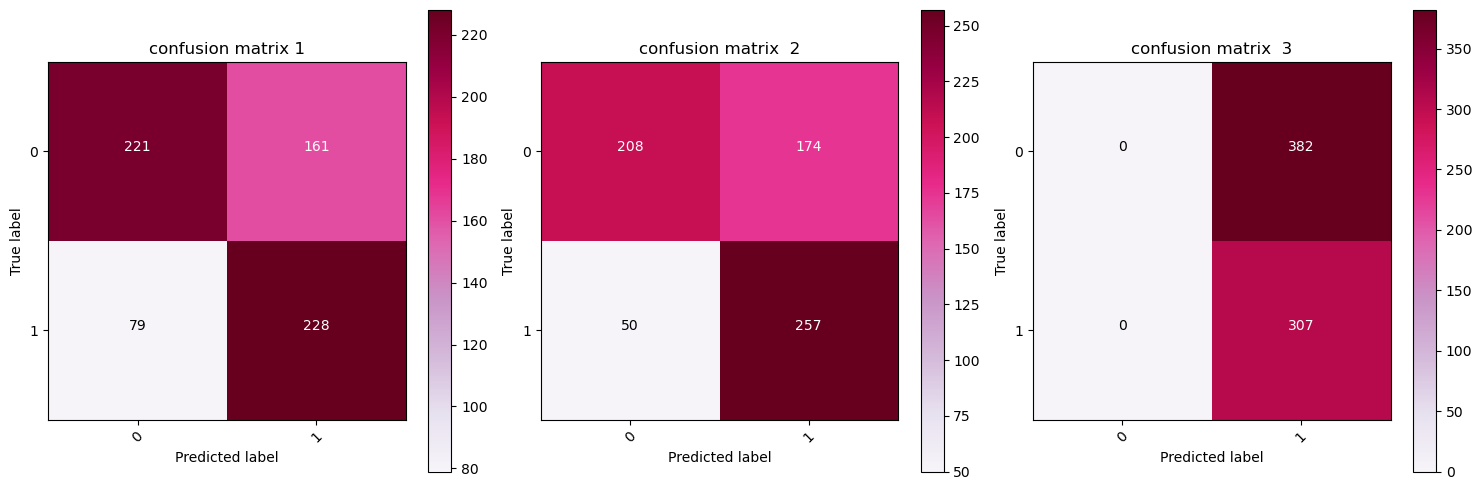

In [17]:
y_true = df['target']

df['pred1_classes'] = (df['pred1_probs'] >= 0.36).astype(int)
df['pred2_classes'] = (df['pred2_probs'] >= 0.27).astype(int)
df['pred3_classes'] = (df['pred3_probs'] >= 0.00).astype(int)

cm1 = confusion_matrix(y_true, df['pred1_classes'])
cm2 = confusion_matrix(y_true, df['pred2_classes'])
cm3 = confusion_matrix(y_true, df['pred3_classes'])

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_confusion_matrix(cm1, classes=[0, 1], title='confusion matrix 1')
plt.subplot(1, 3, 2)
plot_confusion_matrix(cm2, classes=[0, 1], title='confusion matrix  2')
plt.subplot(1, 3, 3)
plot_confusion_matrix(cm3, classes=[0, 1], title='confusion matrix  3')

plt.tight_layout()
plt.show()

**Conclusions:** **Algorithm 2** performs best, as it most effectively classifies people who can repay the loan without losing too many correct cases.

Our objective can also be rephrased:

* **Option 2:** among those to whom the model grants credit, there should be as **few errors as possible** (i.e., few people who actually won’t repay — those are the ones we lose money on).
  At the same time, we don’t want many mistakes overall (total errors no more than **35%**).

1. We don’t want the algorithm to make many mistakes: **accuracy ≥ 0.65**.

2. Additionally, **precision** should be as high as possible (the number in the **top-right** cell of the confusion matrix is minimized).

**Task 7. (0.75 points)** For each algorithm, find a decision **threshold** such that the above conditions are satisfied. What **maximum precision** can each model achieve under the constraint that **accuracy ≥ 0.65**?


In [18]:
precision_results = {}

def find_optimal_thresholds(df, algorithm_index):
    thresholds = np.arange(0.0, 1.0, 0.01) 
    best_precision = 0
    best_threshold = 0
    
    for threshold in thresholds:
        pred_classes = (df[f'pred{algorithm_index}_probs'] >= threshold).astype(int)
        
        accuracy = (pred_classes == df['target']).mean()
        tp = np.sum((pred_classes == 1) & (df['target'] == 1)) 
        fp = np.sum((pred_classes == 1) & (df['target'] == 0))  
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        if accuracy >= 0.65 and precision > best_precision:
            best_precision = precision
            best_threshold = threshold
            
    return best_threshold, best_precision

for i in range(1, 4):  
    optimal_threshold, max_precision = find_optimal_thresholds(df, i)
    precision_results[f'Algorithm {i}'] = (optimal_threshold, max_precision)

print("Algorithm 1: Optimal threshold = {:.2f}, Maximum recall = {:.4f}".format(*precision_results["Algorithm 1"]))
print("Algorithm 2: Optimal threshold = {:.2f}, Maximum recall = {:.4f}".format(*precision_results["Algorithm 2"]))
print("Algorithm 3: Optimal threshold = {:.2f}, Maximum recall = {:.4f}".format(*precision_results["Algorithm 3"]))

Algorithm 1: Optimal threshold = 0.54, Maximum recall = 0.7372
Algorithm 2: Optimal threshold = 0.73, Maximum recall = 0.8367
Algorithm 3: Optimal threshold = 0.00, Maximum recall = 0.0000


**Task 8. (0.5 points)**
Plot the **confusion matrices** for each algorithm using the newly found thresholds.
**Which model handled this objective best?**

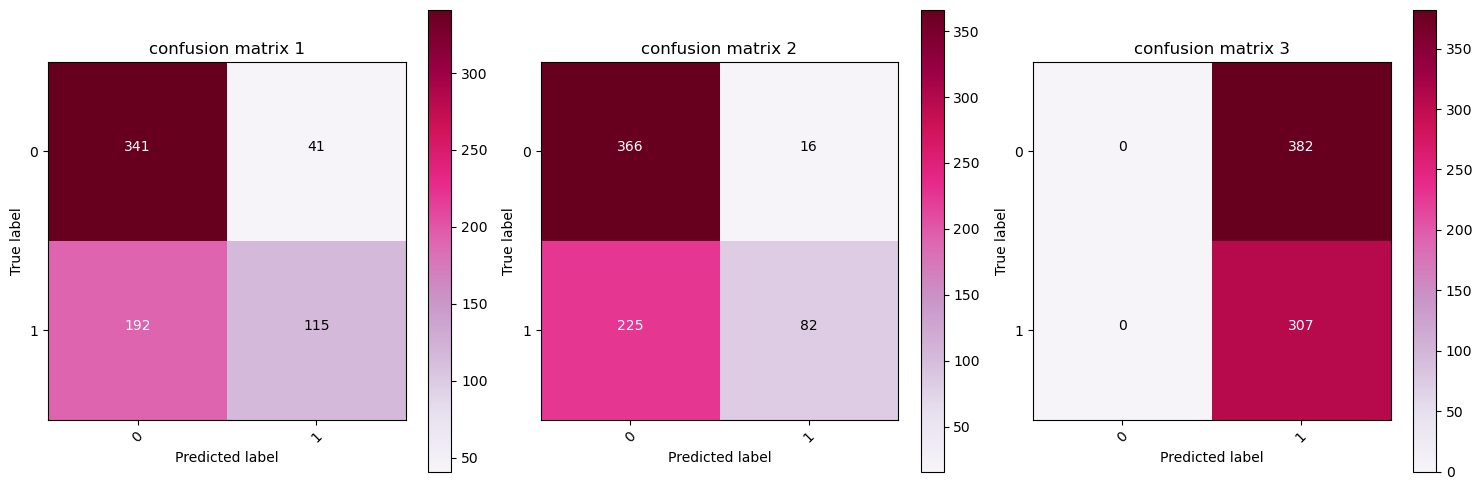

In [19]:
cm1 = confusion_matrix(df['target'], (df['pred1_probs'] >= 0.54).astype(int))
cm2 = confusion_matrix(df['target'], (df['pred2_probs'] >= 0.73).astype(int))
cm3 = confusion_matrix(df['target'], (df['pred3_probs'] >= 0.00).astype(int))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_confusion_matrix(cm1, classes=[0, 1], title='confusion matrix 1')
plt.subplot(1, 3, 2)
plot_confusion_matrix(cm2, classes=[0, 1], title='confusion matrix 2')
plt.subplot(1, 3, 3)
plot_confusion_matrix(cm3, classes=[0, 1], title='confusion matrix 3')

plt.tight_layout()
plt.show()

Task 9. (0.5 points)

Find decision thresholds that maximize F1-score for each of the three models and plot the corresponding confusion matrices. Then state which model performs best for this objective.

Алгоритм 1: Оптимальный порог = 0.36, Максимальный F1-Score = 0.66
Алгоритм 2: Оптимальный порог = 0.32, Максимальный F1-Score = 0.70
Алгоритм 3: Оптимальный порог = 0.00, Максимальный F1-Score = 0.00


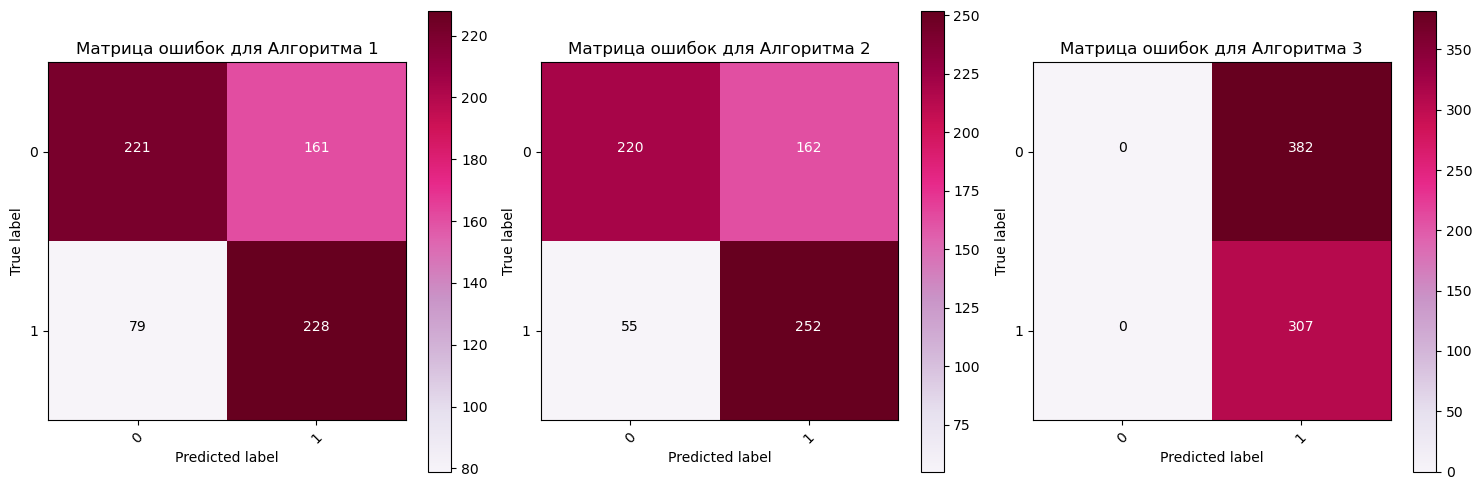

In [43]:
def find_optimal_threshold_for_f1(df, algorithm_index):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_f1 = 0
    best_threshold = 0
    
    for threshold in thresholds:
        pred_classes = (df[f'pred{algorithm_index}_probs'] >= threshold).astype(int)
        
        accuracy = (pred_classes == df['target']).mean()
        precision = precision_score(df['target'], pred_classes)
        recall = recall_score(df['target'], pred_classes)
        f1 = f1_score(df['target'], pred_classes)
        
        if accuracy >= 0.65 and f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            
    return best_threshold, best_f1

f1_results = {}
for i in range(1, 4):  
    optimal_threshold, max_f1 = find_optimal_threshold_for_f1(df, i)
    f1_results[f'Алгоритм {i}'] = (optimal_threshold, max_f1)


for algorithm, (threshold, f1) in f1_results.items():
    print(f'{algorithm}: Оптимальный порог = {threshold:.2f}, Максимальный F1-Score = {f1:.2f}')

cm1 = confusion_matrix(df['target'], (df['pred1_probs'] >= f1_results['Алгоритм 1'][0]).astype(int))
cm2 = confusion_matrix(df['target'], (df['pred2_probs'] >= f1_results['Алгоритм 2'][0]).astype(int))
cm3 = confusion_matrix(df['target'], (df['pred3_probs'] >= f1_results['Алгоритм 3'][0]).astype(int))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)

plot_confusion_matrix(cm1, classes=[0, 1], title='Матрица ошибок для Алгоритма 1')
plt.subplot(1, 3, 2)
plot_confusion_matrix(cm2, classes=[0, 1], title='Матрица ошибок для Алгоритма 2')
plt.subplot(1, 3, 3)
plot_confusion_matrix(cm3, classes=[0, 1], title='Матрица ошибок для Алгоритма 3')

plt.tight_layout()
plt.show()

#### Кстати

В python есть удобная функция classification_report, которая выводит значения нескольких метрик.

In [44]:
from sklearn.metrics import classification_report

print(classification_report(df['target'],df['pred1_classes']))

              precision    recall  f1-score   support

           0       0.74      0.58      0.65       382
           1       0.59      0.74      0.66       307

    accuracy                           0.65       689
   macro avg       0.66      0.66      0.65       689
weighted avg       0.67      0.65      0.65       689



надеюсъ норм, что я итак ей пользовалась ;)

### Обучим свою модель для предсказания target.

**Задание 10. (0.5  баллов)** Отнормируйте признаки в задаче и обучите логистическую регрессию предсказывать target.

In [45]:
X = df.iloc[:, :-4] 
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=16)


model = LogisticRegression(random_state=16)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00        59

    accuracy                           1.00       138
   macro avg       1.00      1.00      1.00       138
weighted avg       1.00      1.00      1.00       138



**Задание 11. (0.5  баллов)** Подберите порог для перевода предсказания в классы, чтобы максимизировать:
    а) точность 
    б) полноту 
    в) f1-score. 
Лучше ли логистическая регрессия справилась с задачей, чем три готовые модели, предсказания которых мы анализировали выше?

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.2, random_state=16)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_probs = log_reg.predict_proba(X_test)[:, 1]

def find_optimal_threshold(y_true, y_probs, metric):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_metric_value = 0
    best_threshold = 0
    
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        
        if metric == 'precision':
            metric_value = precision_score(y_true, y_pred)
        elif metric == 'recall':
            metric_value = recall_score(y_true, y_pred)
        elif metric == 'f1':
            metric_value = f1_score(y_true, y_pred)
        else:
            raise ValueError("Unknown metric")
        
        if metric_value > best_metric_value:
            best_metric_value = metric_value
            best_threshold = threshold
            
    return best_threshold

metrics = ['precision', 'recall', 'f1']
thresholds = {}

for metric in metrics:
    optimal_threshold = find_optimal_threshold(y_test, y_probs, metric)
    thresholds[metric] = optimal_threshold
print(thresholds)

{'precision': 0.9, 'recall': 0.0, 'f1': 0.39}


### Вывод
Оптимальные пороги для recall и f1 отличаются от порогов, найденных в предложенных вариантах. Алгоритмы из вариантов 1 и 2 показали лучшие значения recall с более низкими порогами, в то время как ваш результат для f1 близок к порогам в варианте 3.

В целом, логистическая регрессия показала хорошие результаты, но готовые модели лучше настроены для ситуаций, где нужно сбалансировать несколько метрик.